<div style="text-align: center;">
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

# H-Series Queue Visibility

To run quantum programs on H-Series emulators and devices, users must submit jobs using either `pytket` with the `pytket-quantinuum` extensions, or the Quantinuum API directly. Quantinuum recommends all end users use `pytket` to submit jobs to H-Series. A H-Series job using `pytket` consists of a `circuit` and a `result`. Circuits contain the instructions for running a program on the quantum computer, and are submitted to a user-specified emulator or device. Once the circuit has completed execution on H-Series, a result is available to view by the end user.

Jobs submitted to the H-Series emulators and devices enter a fair queuing system. Jobs will wait in the queue until they run on the target device. A fair queuing process is used to ensure each organization’s queue is equally represented for machine access. The jobs submitted by users in the same organization are executed in the submission order. If users submit a job to a specific machine that is not available, the jobs will remain at the top of an organization’s queue until that machine is available. Machines do not need to be online when submitting jobs. Users are encouraged to submit jobs at their convenience. The H-Series quantum computers are periodically taken down for upgrades. If a job is submitted while the machine is in an upgrade cycle, it will remain in the queue and run when the machine is back online. Users are able and encouraged to submit jobs to the queue.

The [Quantinuum user portal]([https://um.qapi.quantinuuum.com]) displays all jobs submitted to the queue for a specific user. [`pytket`](https://tket.quantinuum.com/api-docs) and its [extension for the H-Series device](https://tket.quantinuum.com/extensions/pytket-quantinuum) can be used to programmatically retrieve queue visibility information. 

**Contents**
* [H-Series Fair-share Queuing System](#H-Series-Fair-share-Queuing-System)
* [Minimise H-Series Queue Time](#Minimise-H-Series-Queue-Time)
* [Queue Visibility in the User Portal](#Queue-Visibility-in-the-User-Portal)
* [Queue Visibility with `pytket`](#Queue-Visibility-with-pytket)
* [Calendar Visualisation](#Calendar-Visualisation)

## H-Series Fair-share Queuing System

The fair-share queue fairly distributes access opportunities to H-Series quantum computers and emulators across users from all organizations. The fair-share queue is an important step in the H-Series software stack for scheduling jobs on H-Series and maximizing compute on the hardware.

### Job Selection

Job selection with the fair-share queue is determined by H-System Quantum Credits (HQCs) accumulation per organization, group priority within an organization, user priority within a group and submission date for all jobs of a selected user.

1. HQCs accumulation
    * An organization from all organizations submitting to a target is selected based on the HQC accumulation, how many HQCs have been consumed by the organization, within the Fair Queue Time Window (FQTW).
    * The FQTW is defined to be 2-4 hours.
1. Group Priority
    * Within the selected organization, jobs from User Groups are ranked and chosen according to group priority. 
    * If multiple groups have the same priority, HQC accumulation is used as a secondary criterion to select jobs. Jobs will run first for groups with lower HQC accumulation.
1. User Priority
    * Once a group is selected, the highest priority user is selected.
1. Submission Date
    * The job with the oldest submission date of the selected user begins execution.
1. Job Execution
    * The selected job is chunked into slices based on the number of shots requested by the user and the complexity of the job. Job complexity is determined by the number of two-qubit gates and measurement gates.
    * A slice of a job is a small number of shots that can be executed between calibration runs.
1. Update organization HQC accumulation within FQTW.

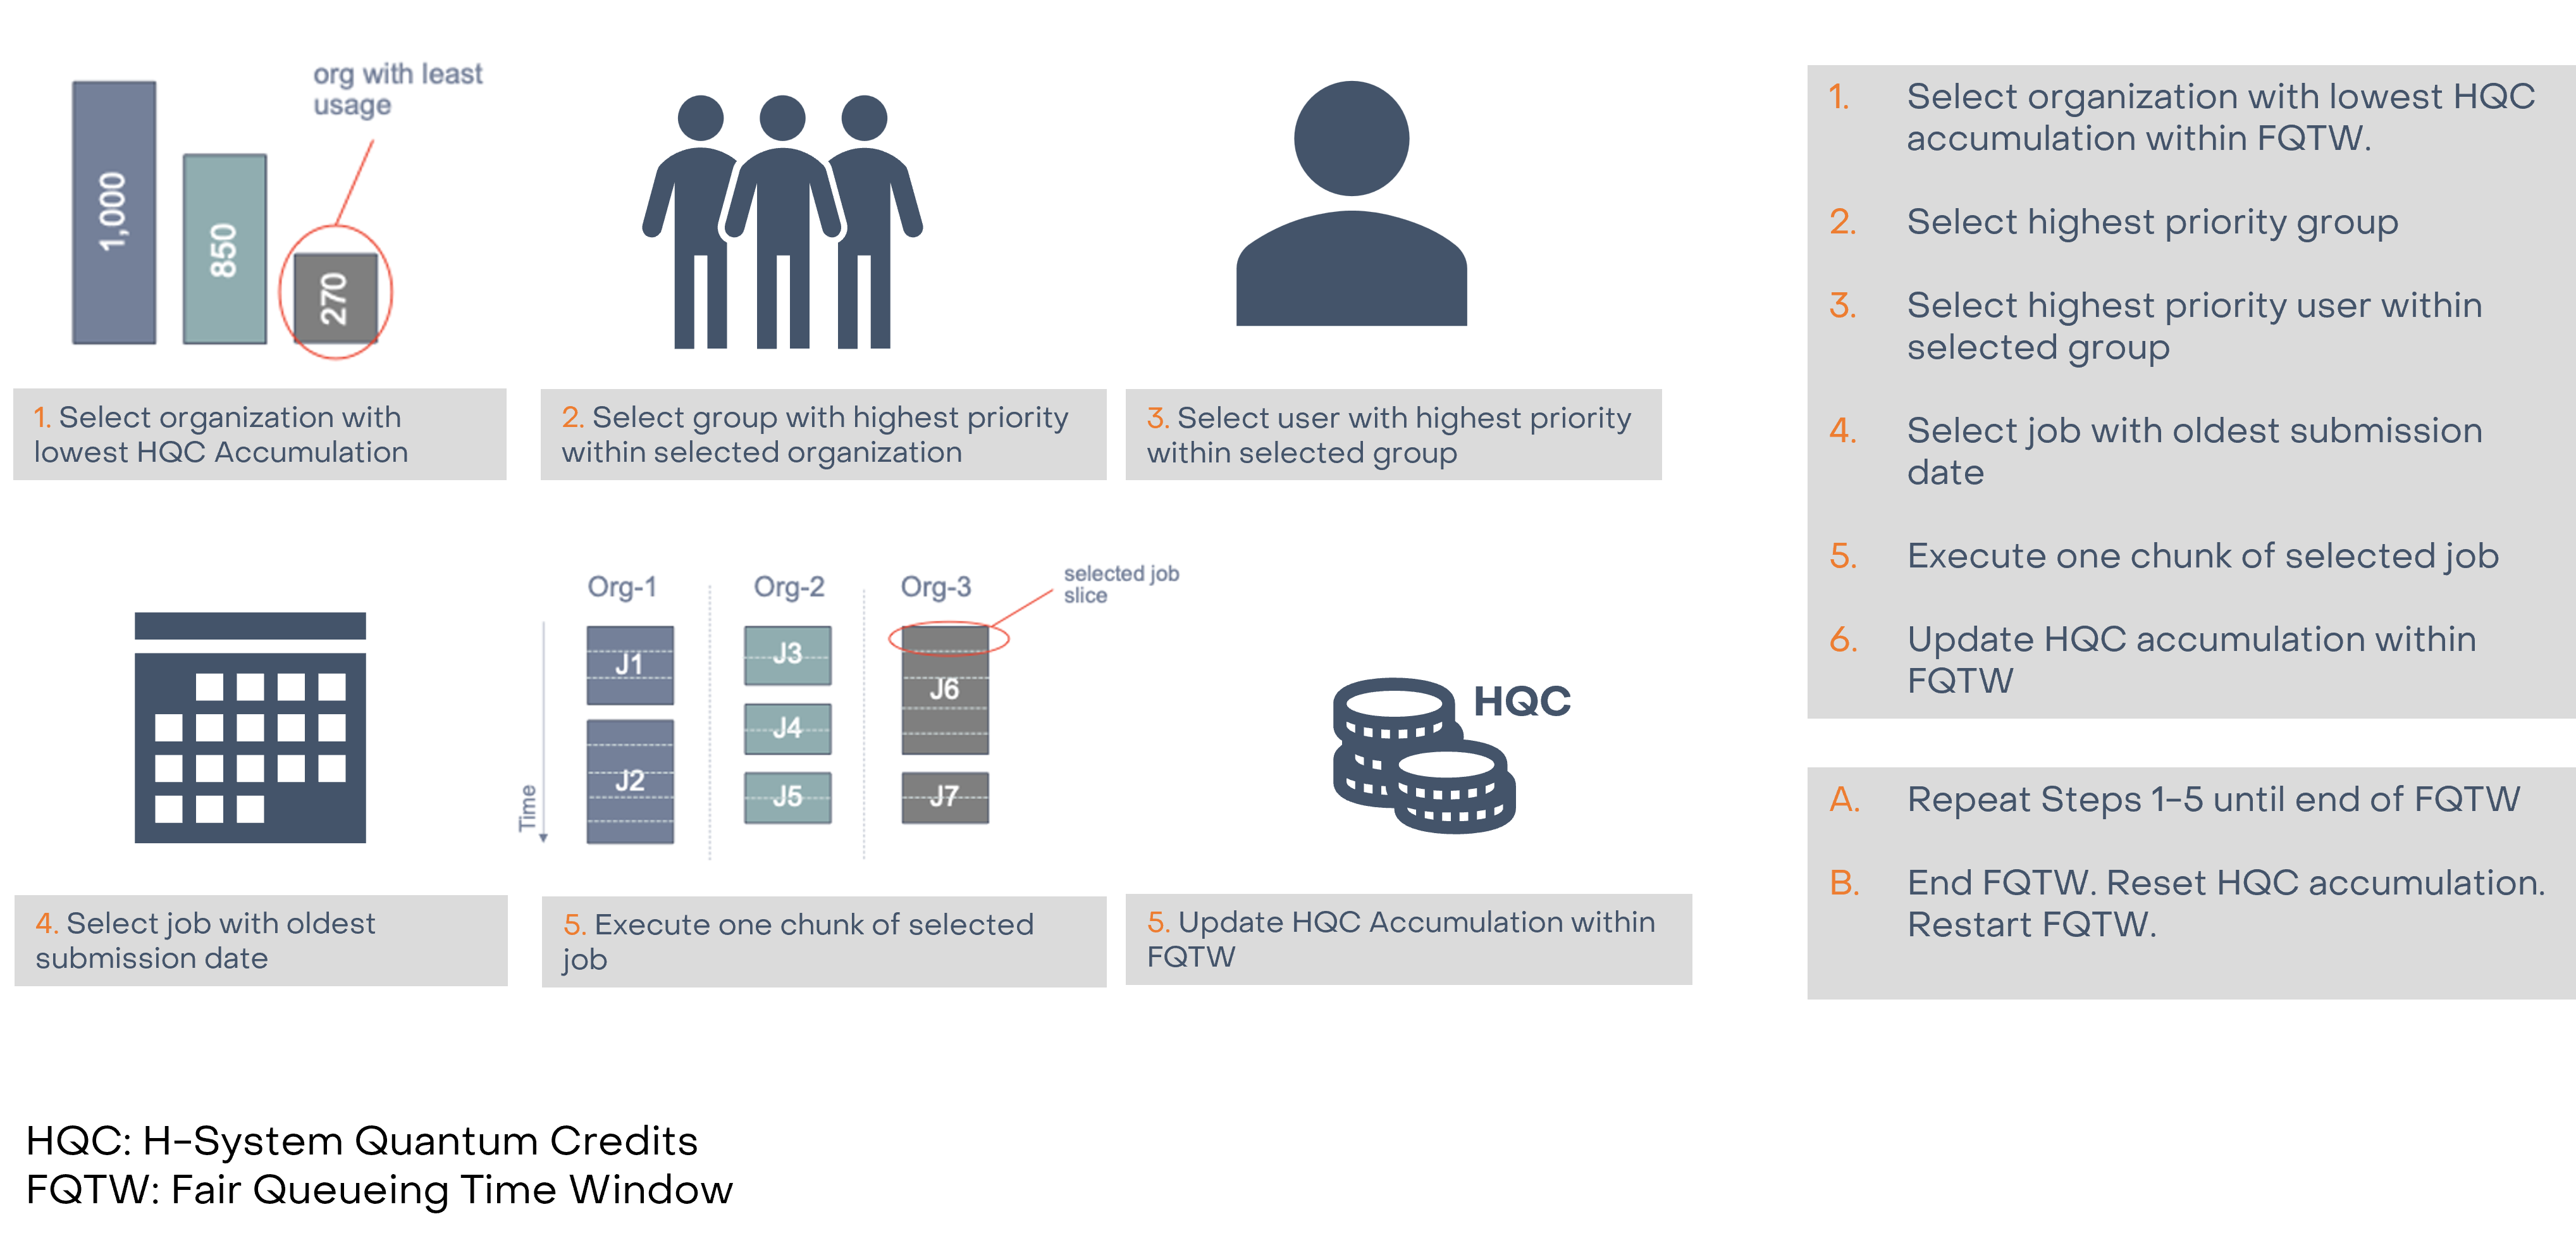

For jobs submitted with large shot counts, jobs are chunked into `slices` with a smaller shot counts. The number of shots in a slice is dynamically chosen by the H-Series compiler and will vary with the complexity of the circuit. 

A series of system checks are performed before and after each slice. If an error is detected, any suspect results are rejected and the failed chunk shots are rerun at no additional cost.

Once a job is selected and starts running, it is assigned a `start date`. Once the job finishes running, it is assigned a `result date`. For jobs consisting of multiple slices, the time between the start date and result date will include all of the system checks and calibrations that happened in the middle of that job and possibly slices from other jobs in the queue. Users should *not* expect that `result date` less `start date` be the system run-time of the job as this is more than likely not the case.

Partial results can be retrieved for the slices that have completed running on the H-series device or emulator using the [`get_partial_results` method](https://tket.quantinuum.com/extensions/pytket-quantinuum/api.html#pytket.extensions.quantinuum.QuantinuumBackend.get_partial_result) in `pytket`.

Jobs running on the emulator will have a runtime dependent on the number of qubits. A 17-qubit emulation may require 10 minutes to complete while a 25-qubit emulation may require over 24 hours to complete.

Fairness is dictated by the HQC accumulation for each organization. Organizations with premium subscriptions will benefit from slower HQC accumulation and therefore will receive higher priority in the fair-share queue.

### Organizations

Users from the same organization submitting jobs to H-Series compete for access through their organization's queue. Organizations consist of users and groups. Multiple users can be in a group and organizations can have multiple users. Organizations can choose whether or not to use user group priorities or user priorities, controlled by organization administrators. If a user has no association with an existing group, they are assigned the `DEFAULT` group of the organization.

* Organization priority (default: 5) is defined between 1 (lowest) and 10 (highest). 
* Higher priority jobs run before lower priority jobs. 
* Jobs not associated with any group are assigned to the `DEFAULT` group with the default group priority (5).

Long queue times can arise if there are several jobs submitted from the same organization.

Organization administrators cannot modify how the fair-share queue selects organizations.

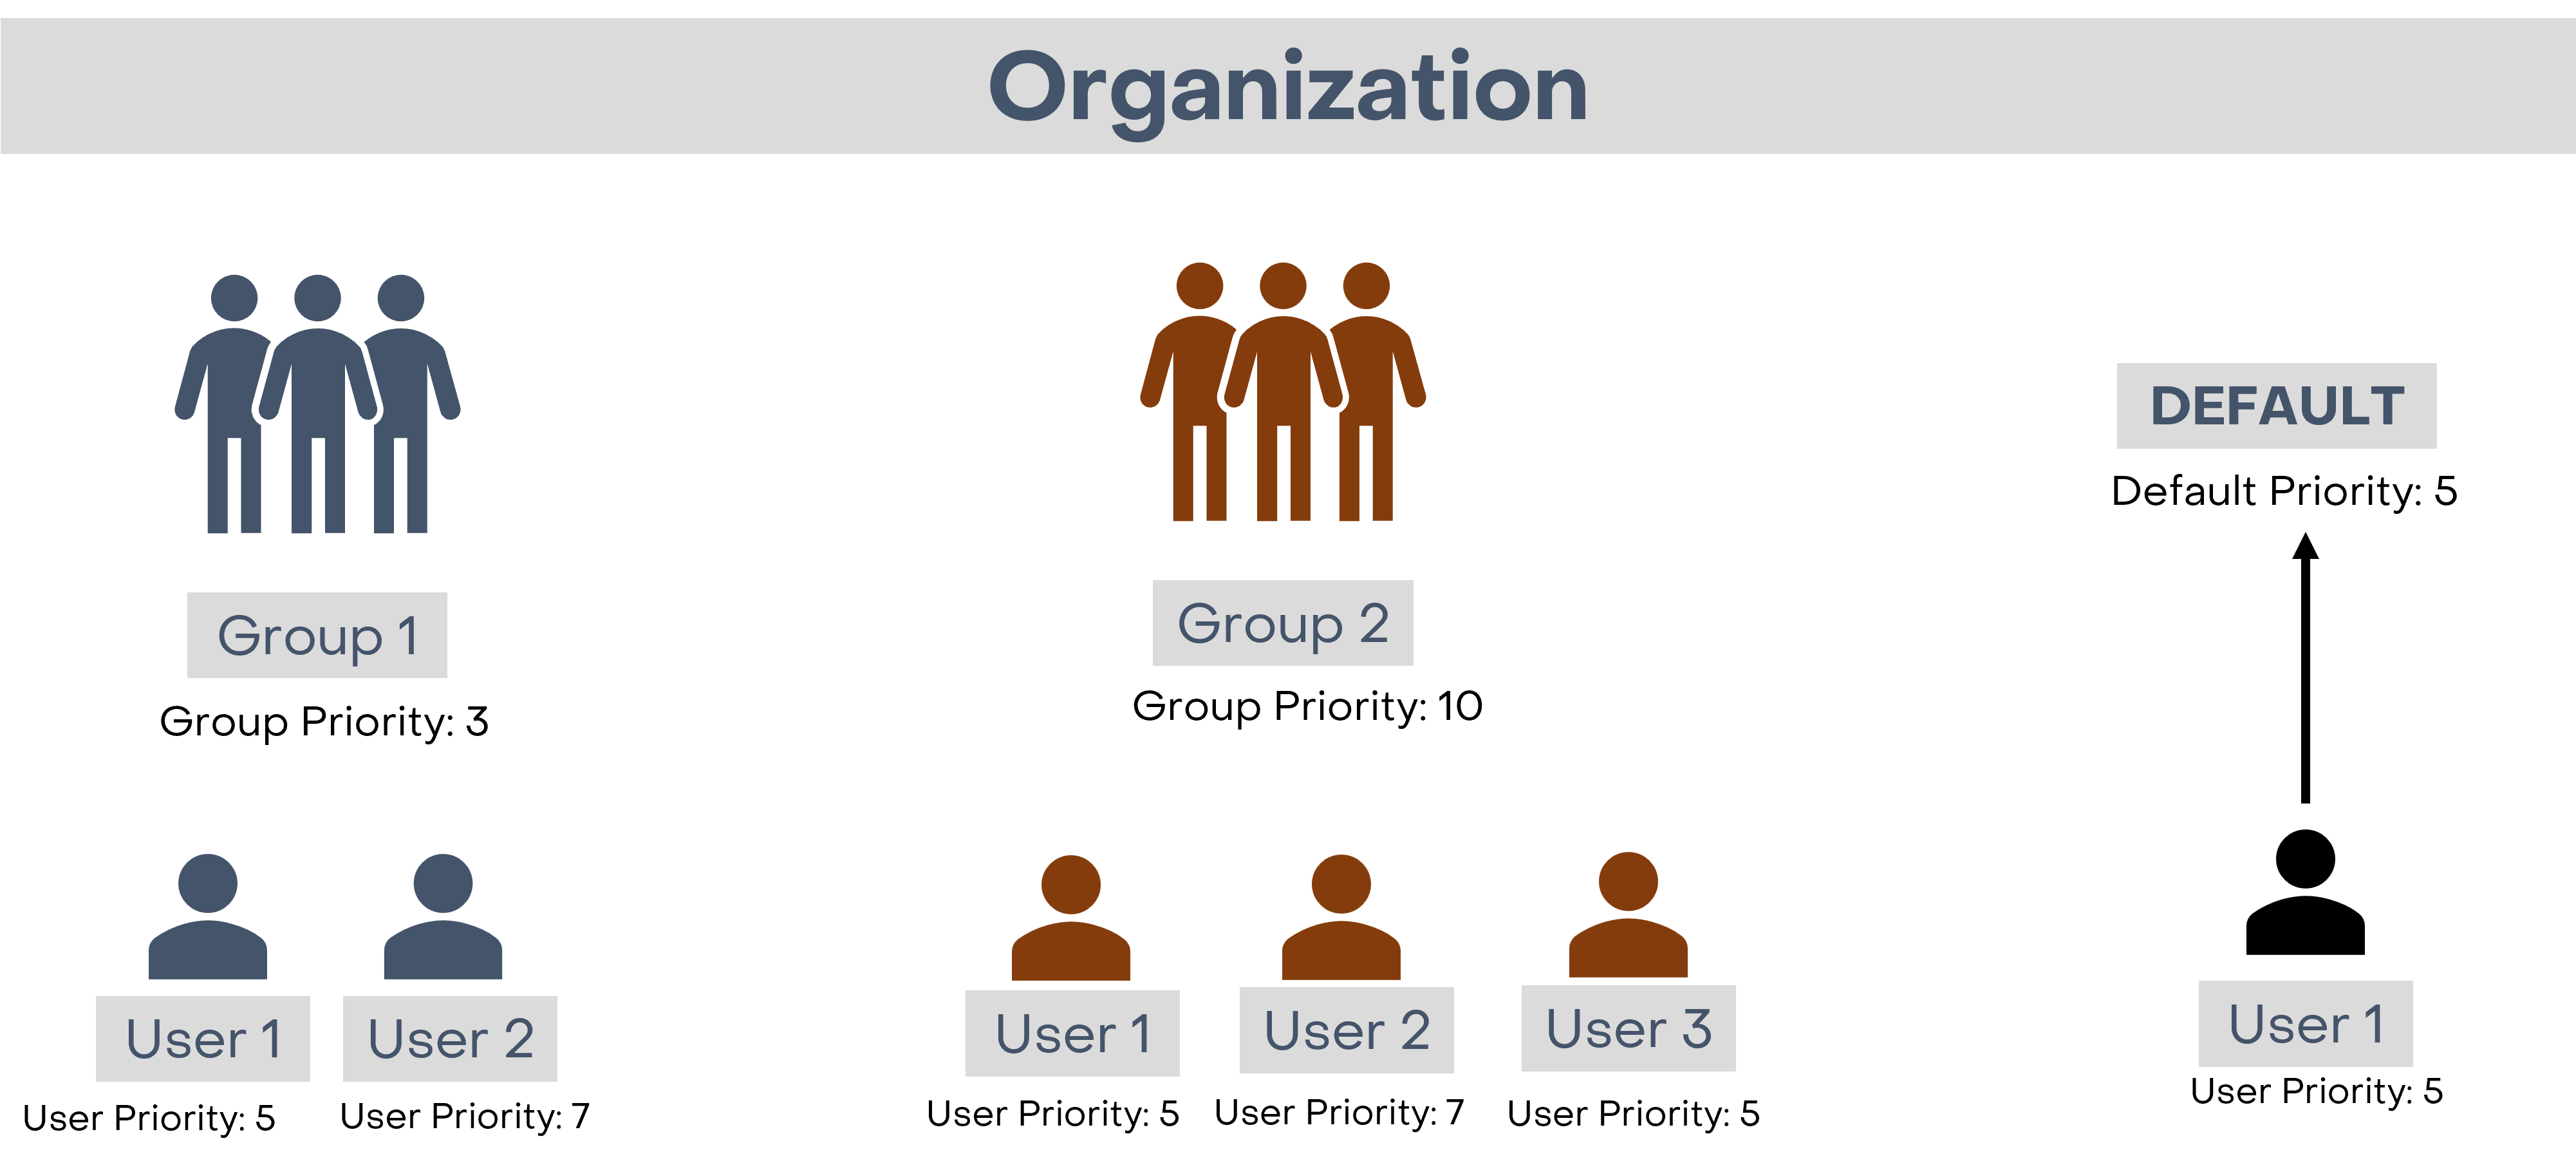

### Minimise H-Series Queue Time

The fair-share queue distributes access to H-Series devices and emulators across multiple organizations. Internally within a selected organization, users can improve the likelihood of their job being selected for execution via communication with the organization administrator. The organization administrator can control user and group priorities to ensure a specific user's jobs start running first within the organization. Group and user priorities can be set by an organization administrator using the user portal or Quantinuum API. The schedule for operations hours on the H-Series device is displayed on the user portal. Emulator targets are readily available to use 24 hours a day.

## Queue Visibility in the User Portal

The Quantinuum user portal for H-Series devices is available at [https://um.qapi.quantinuum.com/](https://um.qapi.quantinuum.com/). To access user-specific queue information, valid credentials are required.

### User-Specific Job View

The user portal displays all jobs submitted by the user. These can be filtered by a date range for job submission.

The user portal job view tabulates the jobs alongside certain properties. These properties are listed below:
* **Status** - If the Job is `Queued`, `Running`, `Completed` or `Failed`
* **Job ID** - A UUID (Universal Unique Identifier) used to reference the job submitted to H-Series.
* **Name** - A user friendly name attached to the job. Useful for filtering jobs in the job view of the user portal. This is set by the user at the point of job submission.
* **Machine** - The emulator or device used for job execution.
* **Group** - The group the job is submitted under.
* **Submit Date** - The date and time the job is submitted to the fair-share queue.
* **Start Date** - The date and time the job starts running on the H-series device or emulator.
* **Shots** - A positive integer specifying how many times to run a circuit in order to generate measurement statistics.
* **Shots Completed** - From the initial number of shots specified, how many shots have been completed.
* **Cost** - The total number of HQCs consumed by a job. All users have a quota of HQCs. Exceeding the number of HQCs restricts the user from submitting more jobs, until the quota of HQCs for that specific-user is replenished.
* **Actions** - Status if a Job has failed, or cancellation of jobs in the queue.

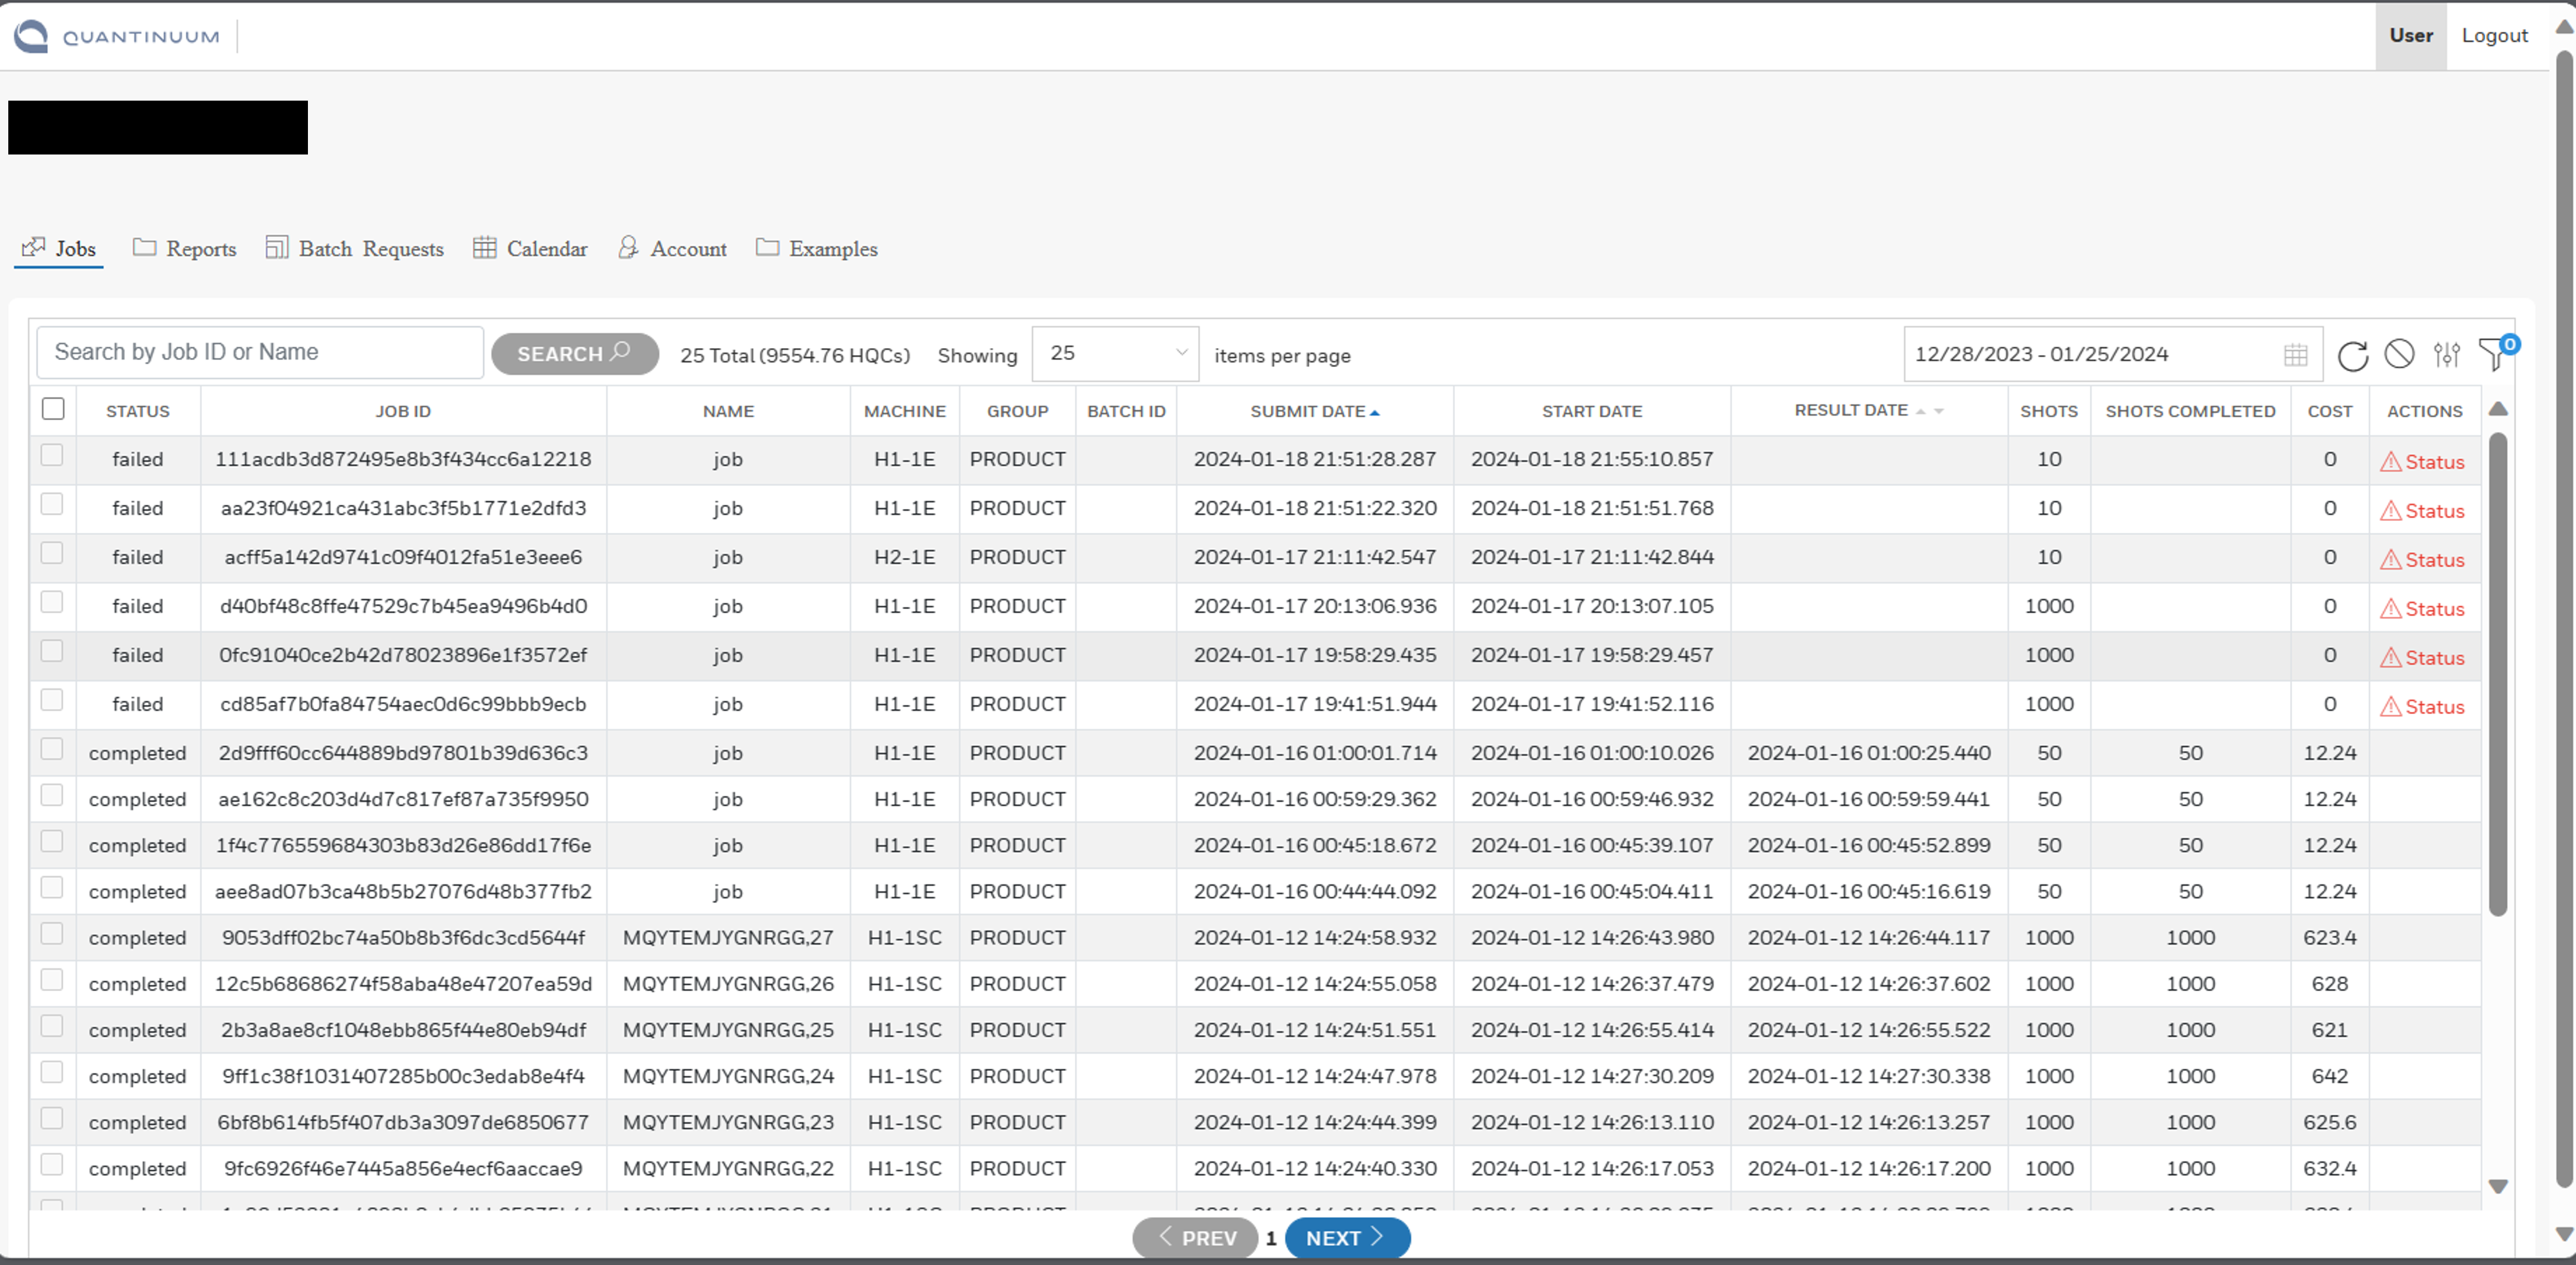

Job position in the queue is determined by order of submission. Jobs submitted first will be executed first.

The job view in the user portal is user specific. It will not show the position of the user's jobs in the organization queue, or reveal information on jobs submitted by other users in the same organization. 

The circuit data and result data available in a job can be retrieved using the Job ID. There are two ways of doing this:
1. With `pytket.backends.ResultHandle`.
2. With the Quantinuum API.

### User-Specific Batch View

The Quantinuum user portal also provides a user-specific view for batch submission. The batch feature gives users the ability to create "ad-hoc" reservations. Circuits submitted together in a batch will run at one time. The benefit to users is that once a batch hits the front of the queue, jobs in a batch will run uninterrupted until they are completed. All batches created by the user are listed in this queue. Like the user-specific job view in the portal, only batches created by the user are listed in the batch-view. Once a batch is submitted, jobs can continue to be added to the batch, ending either when the user signifies the end of a batch or after 1 minute of inactivity. Currently only the quantum computer and emulator targets support the batching feature.

The following properties of a batch submission of jobs are displayed in the user-specific batch view:
* **Batch ID** - This is the job ID for the first job submitted in the batch.
* **Accum. HQC** - Accumulated HQCs for all jobs in the batch that have successfully executed on the specified H-Series emulator or device.
* **Machine** - The emulator or device used for job execution.
* **User** - The user that submitted the circuit to the H-Series queue.
* **Date Submitted** - Date and time of the first job submission in the batch to the H-Series target.
* **Date Started** - Date and time the first job started running in the batch to the H-Series target.
* **Date Completed** - Date and time the last job in the batch completed on the H-Series target.
* **Max HQC** - Maximum allowable consumable HQCs for a specific batch. Batches cannot exceed the maximum limit of 2,000 HQCs total, but a smaller limit can be defined by the user at batch submission. If the total HQCs for jobs in a batch hit this limit or a smaller limit set by the user, those jobs will not be canceled. Instead, they will continue to run as regular jobs in the queue instead of as a batch.

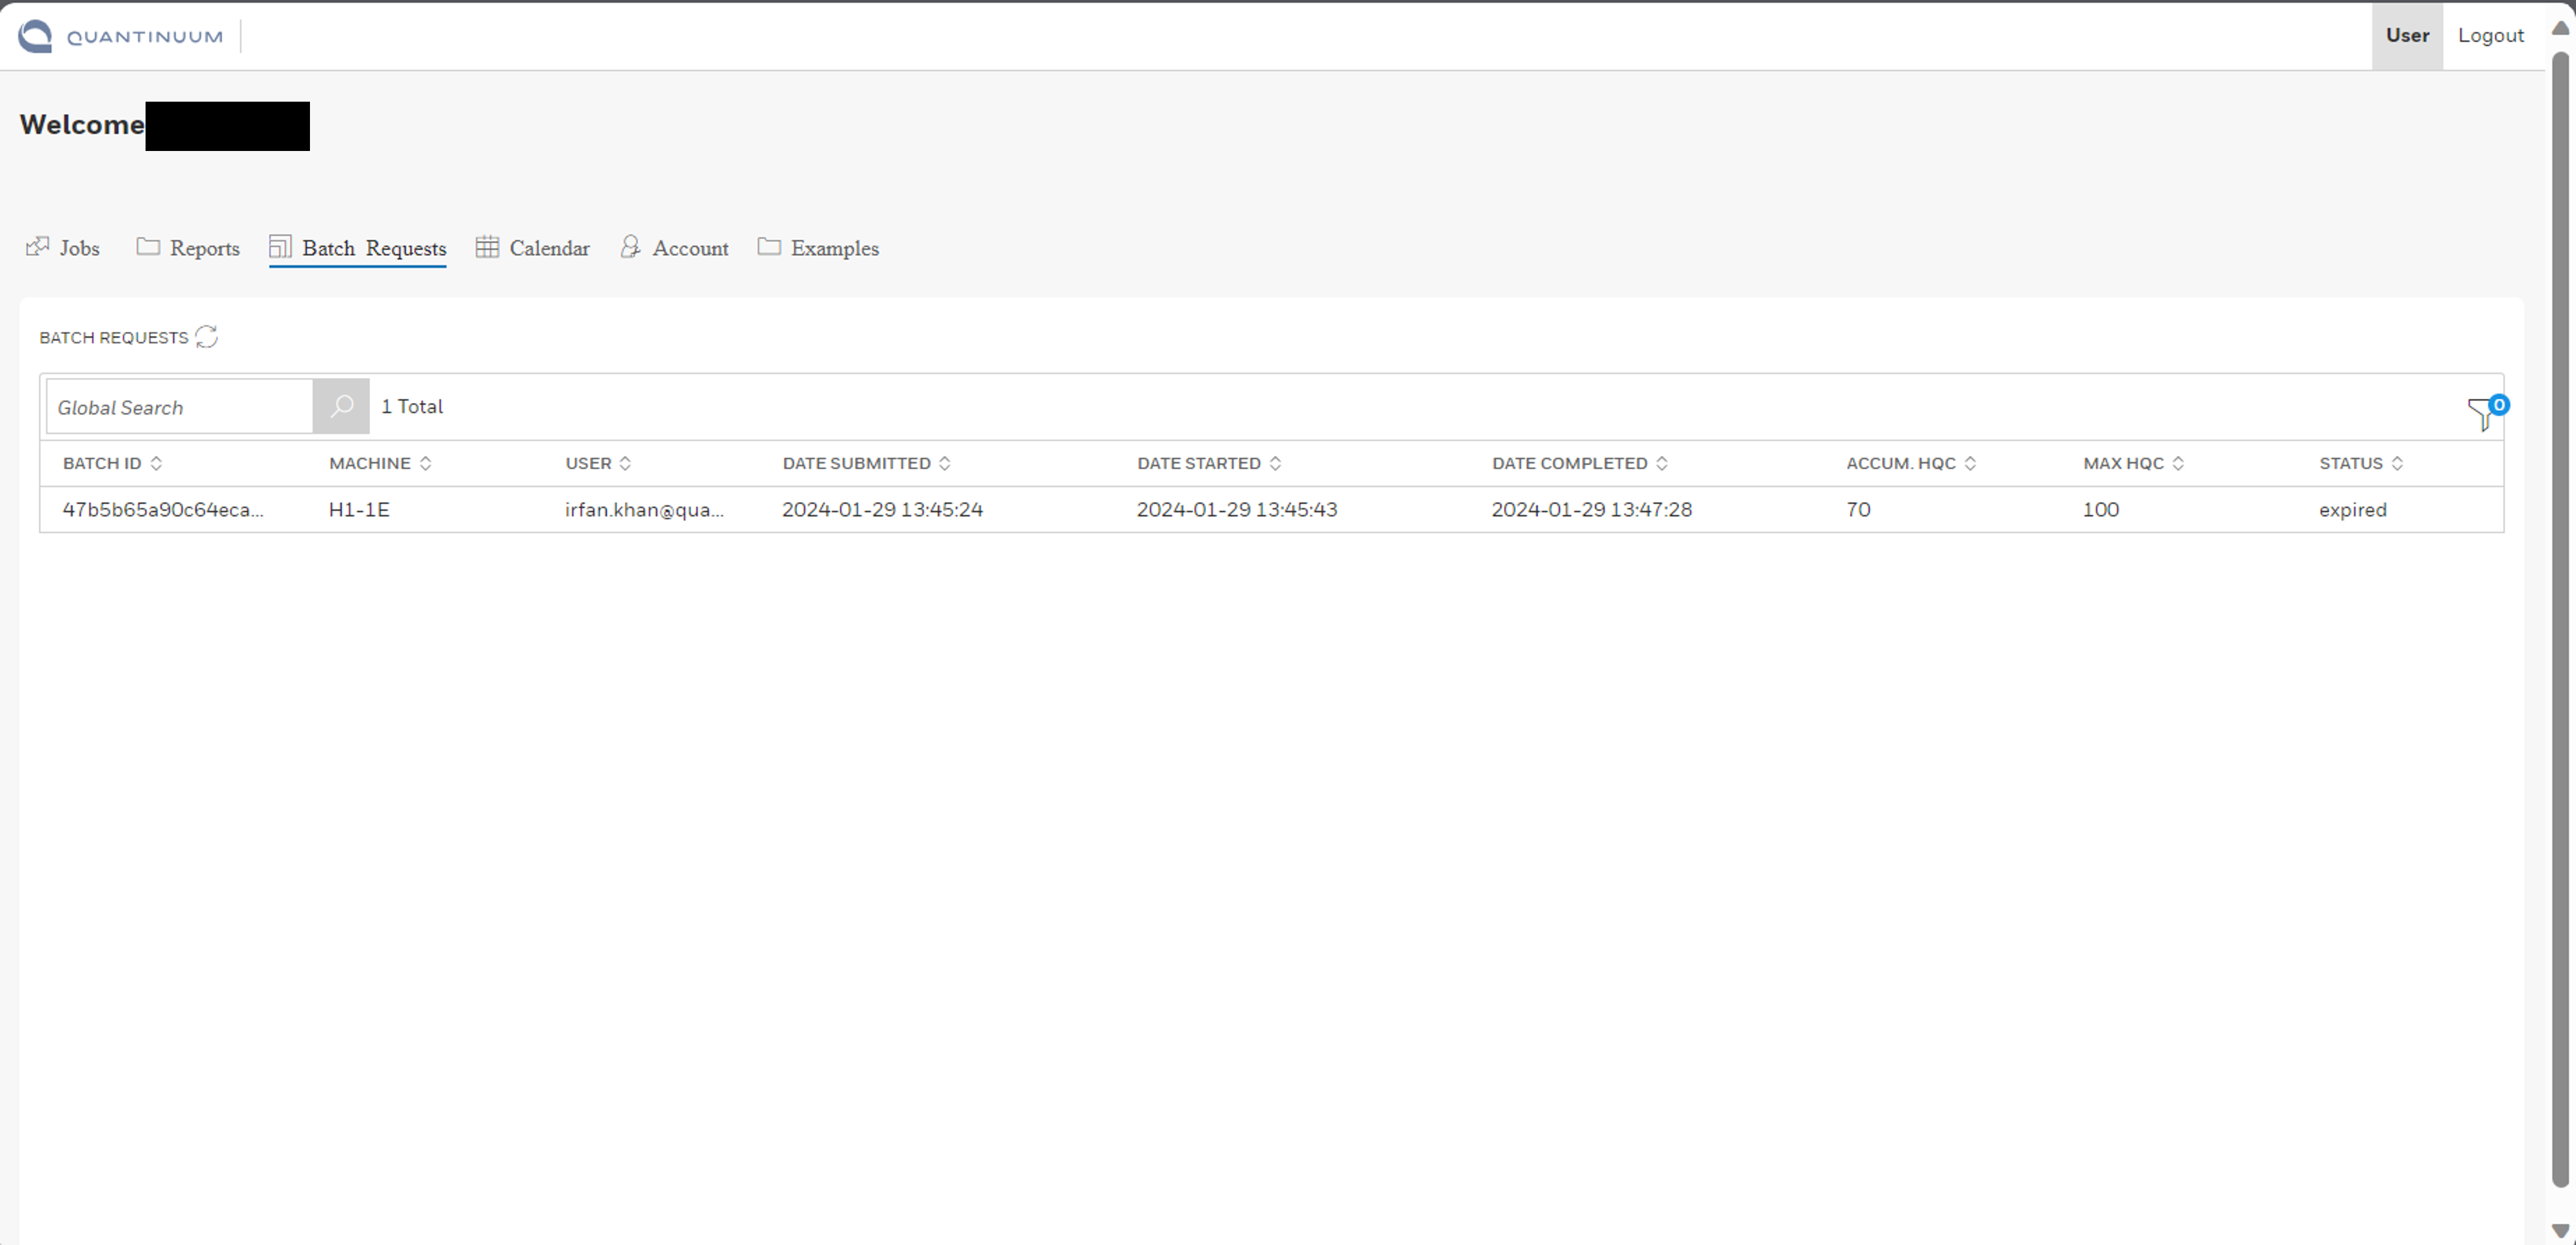

All jobs submitted as part of a batch by a user are visible in that user's job view. Each job in the batch is assigned a `Batch ID` as well as a `Job ID`. The Batch ID is the first job in the batch session. Below, the `PRODUCT` group of the Quantinuum organization has submitted four jobs in a batch session.

The first job is assigned `47b5b65a90c64ecab4ab1088c1f4194f`, the same as the `Job ID`. Each additional job in the batch has its own unique `Job ID`, but retains the same `Batch ID`, `47b5b65a90c64ecab4ab1088c1f4194f`.

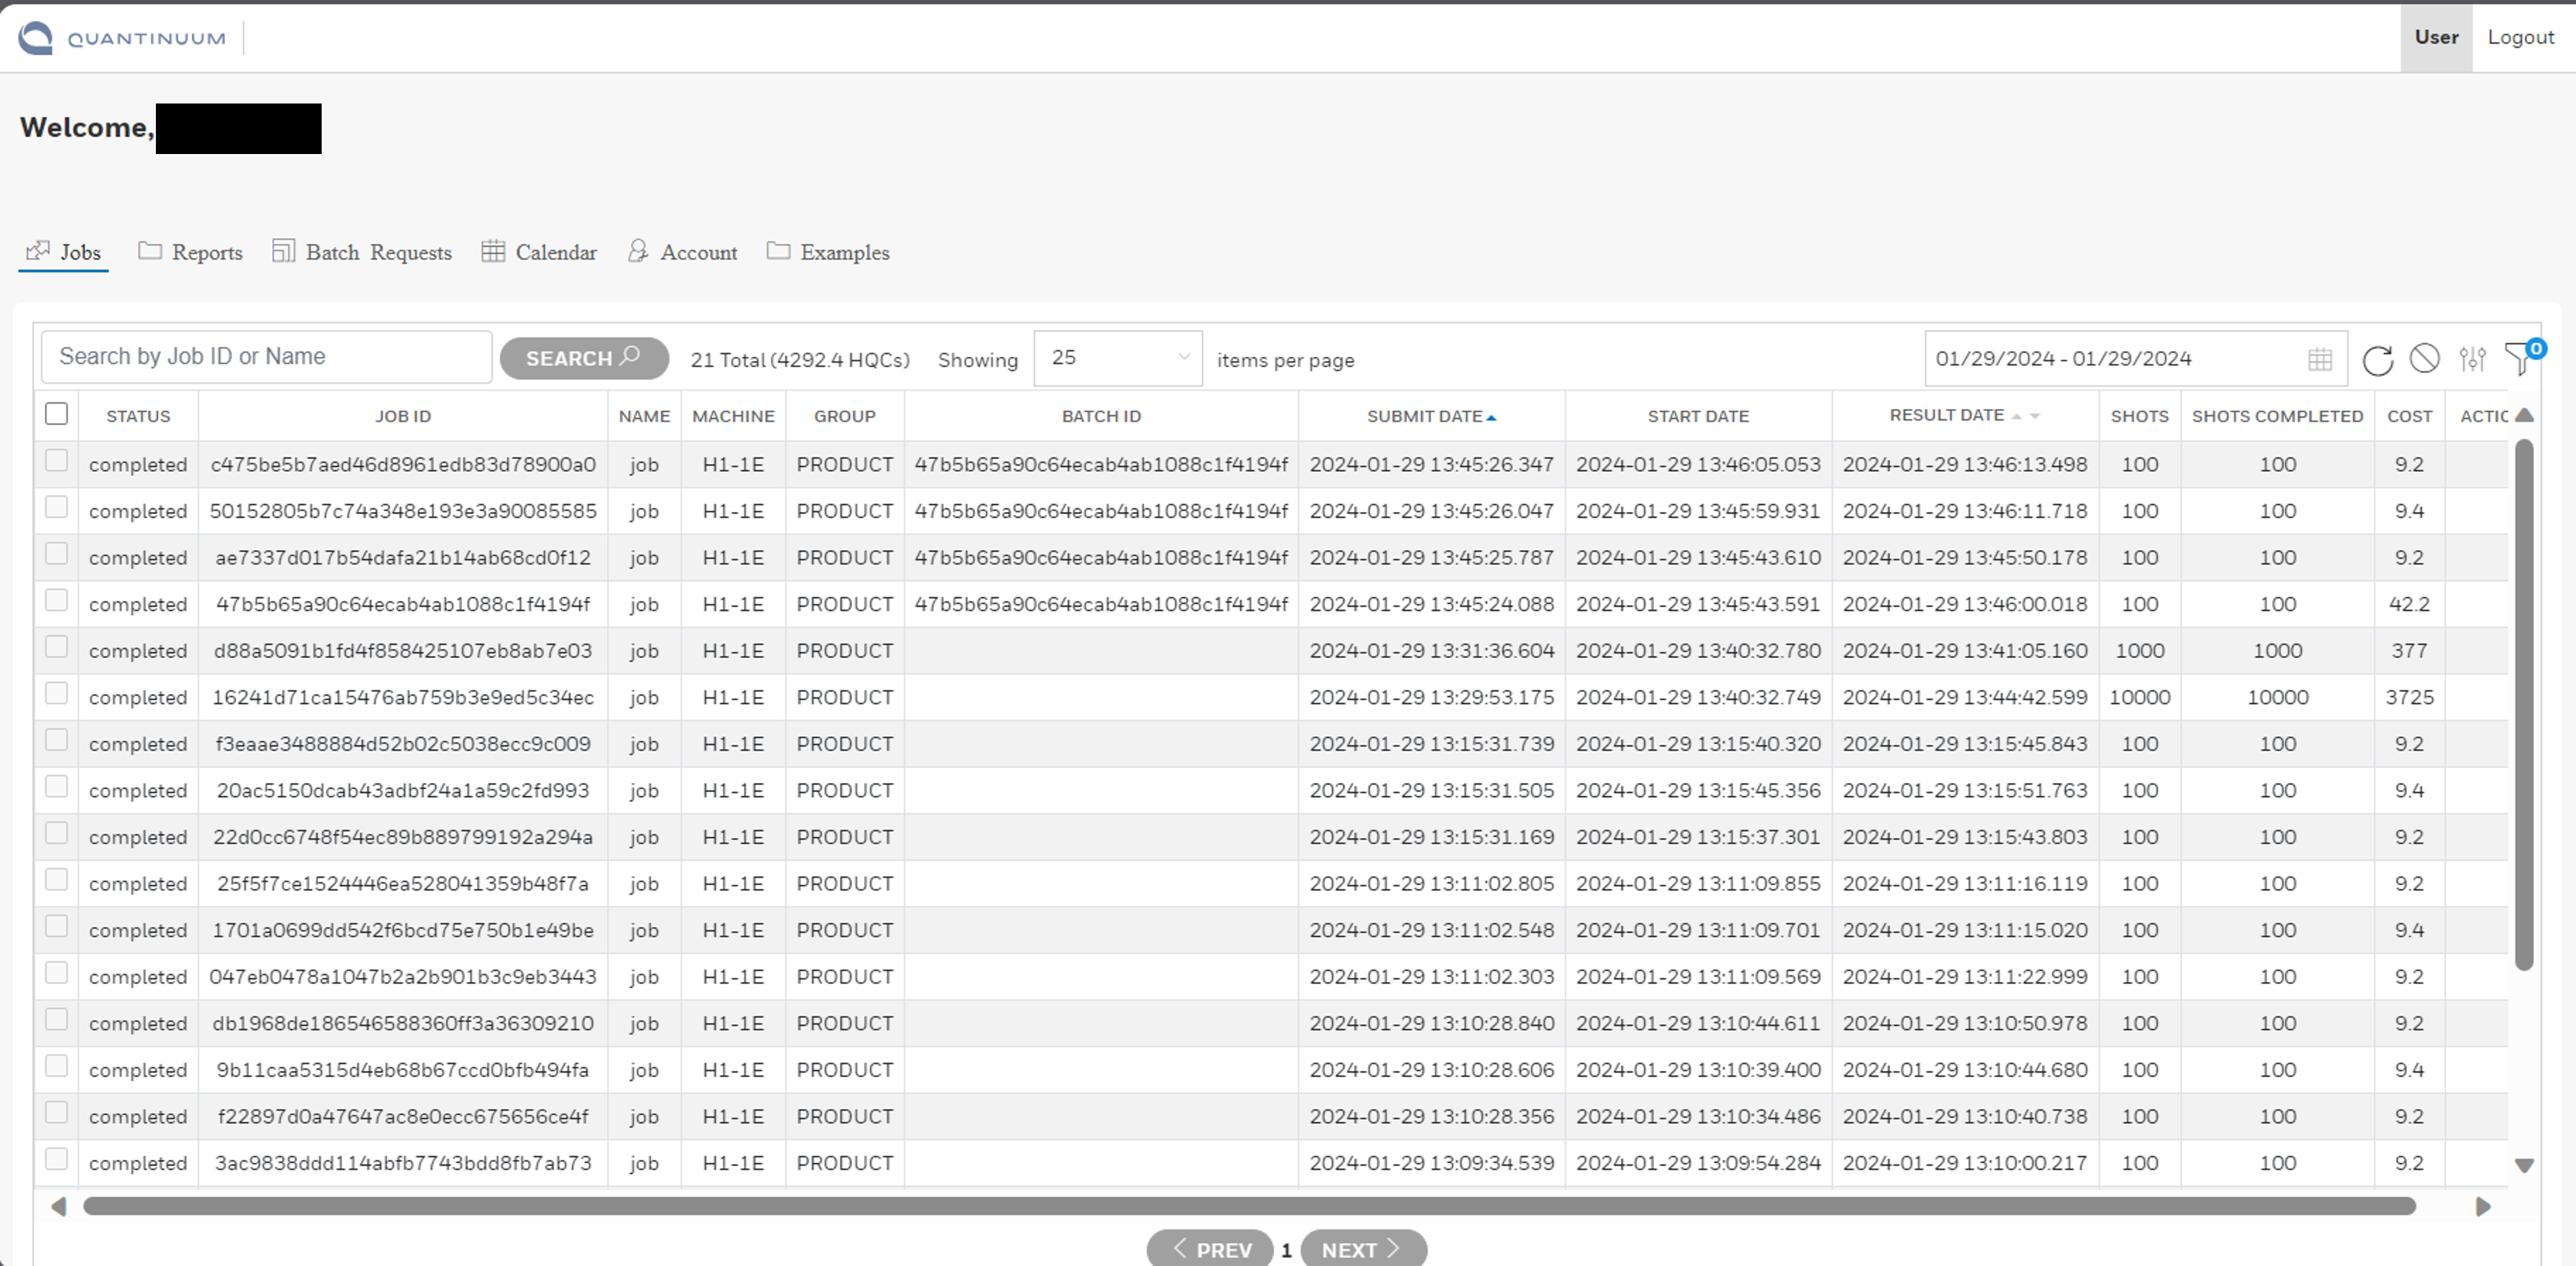

## Queue Visibility with `pytket`

`pytket`, and its extension for H-Series, `pytket-quantinuum`, is used to submit circuits to be executed on H-Series devices and emulators. The overall workflow in `pytket` is to construct a measurement circuit for submission with $n$ shots. Once submitted, a job will appear in H-Series user portal with the status `Queued`. Once the job runs and completes, a result will be available to the end user. `pytket-quantinuum` enables retrieval of the result. Even if the H-series job does not complete, results are partially retrievable with `pytket-quantinuum`.

Job status for jobs on H-Series devices can be queried using `pytket-quantinuum`. The end user should be aware of the different status messages.

* Queued
* Running
* Completed
* Submitted
* Error
* Cancelled

In `pytket`, an object called [`CircuitStatus`](https://tket.quantinuum.com/api-docs/backends.html#pytket.backends.status.CircuitStatus) is used which stores the job status, relevant messages and other useful metadata, such as completion time.

In the cell below, [`QuantinuumBackend`](https://tket.quantinuum.com/extensions/pytket-quantinuum/api.html#pytket.extensions.quantinuum.QuantinuumBackend) from `pytket-quantinuum` is initialized and authenticated via the `login` instance method.

In [ ]:
from pytket.extensions.quantinuum import QuantinuumBackend

backend = QuantinuumBackend(device_name="H1-1E")
backend.login()

Next, a circuit is prepared using two native H-Series gates, `OpType.PhasedX` and `OpType.ZZMax`.

In [ ]:
from pytket.circuit import Circuit
from numpy.random import random_sample

n_qubits = 10
circuit = Circuit(n_qubits)
px_angles = random_sample(n_qubits)

for i in range(n_qubits):
    circuit.PhasedX(px_angles[i], px_angles[i], i)

for (i, j) in zip(range(0, n_qubits - 1), range(1, n_qubits)):
    circuit.ZZMax(i, j)

for i in range(n_qubits):
    circuit.PhasedX(px_angles[i], px_angles[i], i)

The circuit is submitted to H-series using the [`process_circuit`](https://tket.quantinuum.com/extensions/pytket-quantinuum/api.html#pytket.extensions.quantinuum.QuantinuumBackend.process_circuits) call with 10 shots. It is recommended to save this result handle to disk.

In [ ]:
result_handle = backend.process_circuit(circuit, n_shots=10)
result_handle

The `QuantinuumBackend` method [`circuit_status`](https://tket.quantinuum.com/extensions/pytket-quantinuum/api.html#pytket.extensions.quantinuum.QuantinuumBackend.circuit_status) enables status retrieval from H-series of the job just submitted.

In [ ]:
status = backend.circuit_status(result_handle)

The `status` variable is the pytket object [`pytket.backends.CircuitStatus`](https://tket.quantinuum.com/api-docs/backends.html#pytket.backends.status.CircuitStatus). 

The `status` property of `CircuitStatus` returns the enum `ERROR`.

In [ ]:
status.status

The `message` property of `CircuitStatus` returns the status message as a python dictionary. This particular status message reports a compile error at the `QASM` level. The submitted circuit does not contain any measurement gates.

In [ ]:
from pprint import pprint

pprint(status.message)

### Submitting to the Queue and Job Status

The next set of code cells add measurement gates to a copy of the original circuit and submit again via the `pytket` `QuantinuumBackend` to the H-Series device.

In [ ]:
measurement_circuit = circuit.copy()
measurement_circuit.measure_all()

result_handle1 = backend.process_circuit(measurement_circuit, n_shots=100)

In [ ]:
circuit_status1 = backend.circuit_status(result_handle1)

The circuit has been successfully submitted to the H-Series queue. Since the H-Series service operates a fair-share queue, the position in the queue is not available. 

If the user wishes to know the priority and position of their job within their organization queue, they must contact an administrator for their organization. 

In [ ]:
circuit_status1.status

In [ ]:
pprint(circuit_status1.message)

In the code cells below, we refresh the circuit status. The refreshed `CircuitStatus` object reports the job as Completed and confirms the results are available for retrieval.

In [ ]:
circuit_status1_refresh = backend.circuit_status(result_handle1)

In [ ]:
circuit_status1_refresh.status

### Retreiving Results

The results can be retrieved using the [`get_result`](https://tket.quantinuum.com/extensions/pytket-quantinuum/api.html#pytket.extensions.quantinuum.QuantinuumBackend.get_result) method on `QuantinuumBackend`. This returns a [`pytket.backends.resulthandle.ResultHandle`](https://tket.quantinuum.com/api-docs/backends.html#pytket.backends.resulthandle.ResultHandle) result object.

In [ ]:
result1 = backend.get_result(result_handle1)
pprint(result1.get_distribution())

### Cancelling Jobs

A circuit submitted to H-Series can also be canceled after submission using `QuantinuumBackend`'s [`cancel`](https://tket.quantinuum.com/extensions/pytket-quantinuum/api.html#pytket.extensions.quantinuum.QuantinuumBackend.cancel) method. Subsequently, `CircuitStatus` reports the status as Canceled.

In [ ]:
result_handle2 = backend.process_circuit(measurement_circuit, n_shots=10)
backend.cancel(result_handle2)

In [ ]:
circuit_status2 = backend.circuit_status(result_handle2)

In [ ]:
circuit_status2.status

### Submitting Multiple Jobs

A list of circuits submitted to H-Series are all added to the queue. The first circuit in the list is the first circuit in the user's queue and will be run first when the user is selected by the fair-share queue. The last circuit in the list is the last circuit in the user's queue, and will be run last when the user is selected. Other users within the same organization may have jobs that run first based on user and group priorities.

In [ ]:
circuit_list = [
    measurement_circuit,
    circuit.copy().ZZMax(0, 1).measure_all(),
    circuit.copy().Rz(0.5, 0).Rz(-0.5, 1).measure_all(),
]
result_handles = backend.process_circuits(circuit_list, n_shots=100)

In [ ]:
for r in result_handles:
    job_id = backend.get_jobid(r)
    job_status = backend.circuit_status(r)
    print(
        f"Job ID: {job_id} \n Job Status: {job_status.status} \n {job_status.message}\n\n"
    )

### Partial Results

Partial Results can be obtained for circuits that are still running and have completed a percentage of specified shots. Partial results enable users to quickly validate basic execution for very large jobs which may take days to complete. This is useful for jobs that are chunked into slices. The partial results retrieval will allow results for all completed slices to be returned to the user.

In [ ]:
circuit_partial = circuit.copy()
for _ in range(3):
    c = circuit_partial.copy()
    circuit_partial.append(c)
circuit_partial.measure_all()

handle_pr = backend.process_circuit(circuit_partial, n_shots=10000)

A partial result is requested after a small delay (sleep function delays call to retrieve partial result by 45 seconds) with the [`get_partial_results`](https://tket.quantinuum.com/extensions/pytket-quantinuum/api.html#pytket.extensions.quantinuum.QuantinuumBackend.get_partial_result) function. Results are available for the slices of the job that are complete.

In [ ]:
from time import sleep

sleep(45)

partial_result, job_status = backend.get_partial_result(handle_pr)
print(partial_result)
print(job_status)

### Batch Submission

Quantinuum systems support the ability to run job batches. The batch feature gives users the ability to create "ad-hoc" reservations. 
Circuits submitted together in a batch will run at one time. The benefit to users is that once a batch hits the front of the queue, 
jobs in a batch will run uninterrupted until they are completed. Once a batch is submitted, jobs can continue to be added to the batch, 
ending either when the user signifies the end of a batch or after 1 minute of inactivity. Batches cannot exceed the maximum limit of 2,000 HQCs total. However, this is dependent on each organization and their plan. If the total HQCs for jobs in a batch hit this limit or a smaller limit set by the user, those jobs will not be canceled. Instead, they will continue to run as regular jobs in the queue instead of as a batch.

In [ ]:
batch_handle = backend.start_batch(
    max_batch_cost=100, circuit=circuit_partial, n_shots=100
)

handle_list = []
for circ in circuit_list:
    handle = backend.add_to_batch(batch_handle, circuit=circ, n_shots=100)
    handle_list.append(handle)

In [ ]:
print(backend.get_jobid(batch_handle))
backend.circuit_status(batch_handle)

In [ ]:
for h in handle_list:
    print(backend.get_jobid(h))
    print(backend.circuit_status(h), "\n")

Batching information is visible in the user portal. Each job submitted as part of a batch session, will have a `Batch ID` as well as a `Job ID`. The `Job ID` is the unique universal id displayed in the output above. The `Batch ID` is the first `Job ID` submitted in the batch session.

## Calendar Visualisation

H-Series users can visualise periods of H-Series operations using the `QuantinuumBackend.get_calendar` method. The calendar can be visualised using the `calendar_view` python package. The calendar specifies the duration the device is online. Users within an organization also have visibility on reservations for their own organization. 

The `QuantinuumBackend` object, instantiated above, can be used to retrieve and visualise the operations calendar for a specific H-Series device. Since, calendar information only exists for the H-Series quantum computers, not the emulators or syntax checkers (targets ending in `E` or `SC`), the backend instance above targeting `H1-1E` cannot be used.

In [ ]:
from pytket.extensions.quantinuum import QuantinuumBackend

quantum_backend = QuantinuumBackend(device_name="H2-1")
quantum_backend.login()

In the cell below, we set the start date and end date for the time frame we want to pull calendar information for. The `start_date` and `end_date` variables are `datetime.date` objects. The response contains a list of dictionaries. Each dictionary contains information on the device availability on one day for the date range given.

In [ ]:
from datetime import datetime

start_date = datetime(2024, 3, 18)
end_date = datetime(2024, 3, 22)
calendar = quantum_backend.get_calendar(start_date, end_date)

By using the method `strftime`, the `datetime.datetime` object can be formatted to enable a more user-friendly display.

In [ ]:
if len(calendar) > 0:
    print(
        "Time Range: ",
        calendar[0].get("start-date").strftime("%Y-%m-%d %H:%M %Z"),
        "-",
        calendar[0].get("end-date").strftime("%Y-%m-%d %H:%M %Z"),
    )

The cell above shows the date in the timezone localised to the system where the method is being called. If you desire to have dates returned in UTC, set `localise`  to `False`, as shown below.

In [ ]:
calendar_utc = quantum_backend.get_calendar(start_date, end_date, localise=False)
if len(calendar) > 0:
    print(
        "Time Range:",
        calendar_utc[0].get("start-date").strftime("%Y-%m-%d %H:%M %Z"),
        "-",
        calendar_utc[0].get("end-date").strftime("%Y-%m-%d %H:%M %Z"),
    )

The data can be passed into a pandas `DataFrame` to visualise as a table. The python library, pandas, can be installed with `pip install pandas`.

In [ ]:
import pandas as pd

df_calendar = pd.DataFrame(calendar)

In [ ]:
df_calendar

`QuantinuumBackend` can also generate a `matplotlib` visualisation using matplotlib, via the `view_calendar` method. To use this, you  must install pytket-quantinuum with the extra calendar install argument: `pip install pytket-quantinuum[calendar]`.

In [ ]:
calendar_figure = quantum_backend.view_calendar(
    month=3, year=2024, figsize=(40, 20), fontsize=17, titlesize=30
)

The calendar figure shows availability for `H1-2` in March, 2024. The calendar shows which days the device is online with fairshare access (highlighted in the calendar). The start date (localised to the end-users timezone) and the duration in hours are provided.

## Summary

The H-Series fair-share queue selects jobs based on HQC accumulation per organization, group priorities, user priorities and submission times within that organization. Users can view the all the jobs submitted to H-Series within the last 90 days via the user portal. The user portal displays the status of the users's jobs as well as other useful meta-data. Users do not have visibility of other users jobs. organization admins can view all the jobs, groups and users within their own organization, but not other organizations. 

`pytket` is a powerful tool to also access this data programmatically. Additionally, `pytket` enables retrieval of partial results whilst jobs are running. The unique H-Series batch feature, to ensure all jobs submitted together (in a batch) run together, is also accessible with `pytket`. The user portal displays information on batch jobs, and `pytket` enables batching to be performed via the end-user's `jupyter` notebook.

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>